In [1]:
from unet import unet_constructor as GUnet
import dataloader as dataloader
from loss import dice_loss, cross_entropy_loss, random_cross_entropy
import transforms as t
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import skimage.io as io
import os




In [2]:
data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.nul_crop(rate=.85),
                                          t.random_crop([256, 256, 30]),
                                          t.random_rotate(),
                                          #t.random_affine()
                                          ],
                        image_transforms=[
                                          t.drop_channel(.8), 
                                          t.random_gamma((.7, 1.3)),
                                          t.random_intensity(),
                                          t.spekle(0.00001),
                                          t.clean_image(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )

val_data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.random_crop([512, 512, 30]),
                                          t.random_rotate(90),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          #t.random_gamma((.8,1.2)),
                                          #t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )



In [3]:
device = 'cuda:0'

test = GUnet(image_dimensions=3,
             in_channels=4,
             out_channels=1,
             #feature_sizes=[16,32,64,128],
             feature_sizes=[32, 64, 128],
             kernel={'conv1': (8, 8, 2), 'conv2': (8, 8, 1)},
             upsample_kernel=(8, 8, 2),
             max_pool_kernel=(2, 2, 1),
             upsample_stride=(2, 2, 1),
             dilation=1,
             groups=2).to(device)


test = test.type(torch.float)

image, mask, pwl = data[0]

out = test.forward(image.float().to(device))
out_loss = dice_loss(out, mask.to(device))#, pwl.float().to('cuda'))



In [4]:
#test.load('May14_chris-MS-7C37_2.unet') # <- BEST YET

sd = 'Jun7_chris-MS-7C37_1.unet'
test.load(sd)
test.cuda()
test.train()
print('Yeet')

Yeet


In [5]:
epoch = 0 
lr = 0.01
gamma = .75
weight_cel = 2
weight_dice = 1
cel_z_weighting_method = 'worst_z'

device = 'cuda:0'                 

epoch_loss = []



In [ ]:
writer = SummaryWriter()

In [6]:

optimizer = torch.optim.Adam(test.parameters(), lr = lr)
#optimizer = torch.optim.SGD(test.parameters(), lr=lr, momentum=.99, nesterov=True)

scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)


In [ ]:
while True:  # loop over the dataset multiple times
    epoch_loss_dice=[]
    epoch_loss_BCE=[]
    epoch_loss_joint=[]
    for i in range(len(data)):
        image, mask, pwl  = data[i]
        
        if torch.isnan(image.float()).any():
            raise ValueError
        if torch.isnan(mask.float()).any():
            raise ValueError('MASK')
        if torch.isnan(pwl.float()).any():
            raise ValueError('PWL')
        if torch.isinf(image.float()).any():
            raise ValueError
        if torch.isinf(mask.float()).any():
            raise ValueError('MASK')
        if torch.isinf(pwl.float()).any():
            raise ValueError('PWL')

        optimizer.zero_grad()
        out = test(image.float().to('cuda'))


        #out_loss = ((np.cos(2*np.pi * (epoch/100))+1)/4 + .2) * cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'), 5) +\
        #           dice_loss(out, mask.to('cuda'))
        out_loss = weight_cel * cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'), weight=cel_z_weighting_method) +\
                   weight_dice * dice_loss(out, mask.to('cuda'))
        
        if torch.isnan(out_loss):
            print(cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda')))
            print(dice_loss(out, mask.to('cuda')))
            print(torch.isnan(mask.float()).any(), torch.isnan(image.float().any()), torch.isnan(pwl.float()).any())
            print(out.shape)
            raise ValueError
        
        del out
        
        epoch_loss_joint.append(out_loss.item())
        
        print(f'\r\033[32mEpoch: \033[0m{epoch} |',end='')
        print(f' JOINT |', end='')
        print(f' {i} |',end='')
        print(f' \033[35mPOL: \033[0m{str(running_loss)[0:8]} -->', end='')
        print(f' \033[35mOL: \033[0m{str(out_loss.item())[0:8]}', end='')

        out_loss.backward()
        optimizer.step()
        

        running_loss = out_loss.item()
        
        del out_loss, mask, pwl 
        
    to_tb = np.array(epoch_loss_joint).sum()/len(epoch_loss_joint)
    writer.add_scalar('Cyclic Joint Loss Train', to_tb, epoch)
    epoch_loss.append(to_tb)
    epoch += 1




In [10]:
hyperparameters =  {'lr': lr,
                    'epoch_final': epoch,
                    'weight_cross_entropy_loss':weight_cel,
                    'weight_dice_loss':weight_dice,
                    'epoch_loss': epoch_loss,
                    'cross_entropy_loss_z_weighting_method': cel_z_weighting_method,
                    'transfer_learning_unet_starting_state_dict_name': sd,
                    'optimizer': optimizer.state_dict()
                   }

test.save('Jun8_chris-MS-7C37_1.unet', hyperparameters)

import numpy as np
from PIL import Image, TiffImagePlugin

loc = '/home/chris/Dropbox (Partners HealthCare)/HcUnet/Data/Feb 6 AAV2-PHP.B PSCC m1.lif - PSCC m1 Merged.tif'

a = Image.open(loc)
b = np.array(a.getdata(), np.uint16)
import ray

ray.init()
import numpy as np
import scipy.ndimage.morphology
import skimage.io as io
from numba import njit


class makePWL:
    def __call__(self, imagepath):
        print(f'STARTING PIXEL WISE LOSS')
        mask = io.imread(imagepath)  # np.uint16
        ms = mask.shape
        bigmask = np.zeros((ms[0], ms[1] + 100, ms[2] + 100, ms[3]))
        bigmask[:, 50:ms[1] + 50, 50:ms[2] + 50, :] = mask
        background = bigmask[0, 0, 0, :]  # np.uint16

        # for z in range(mono_bigmask.shape[0]):
        ##    for x in range(mono_bigmask.shape[1]):
        #        for y in range(mono_bigmask.shape[2]):
        #
        #            if np.any(mono_bigmask[z, x, y, :] != background):
        #                mono_bigmask[z, x, y, :] = np.arra

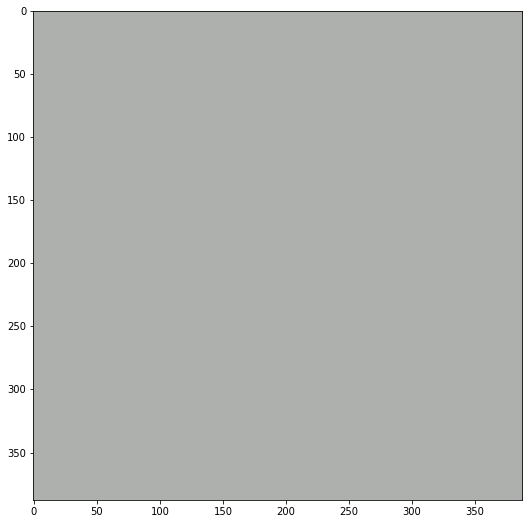

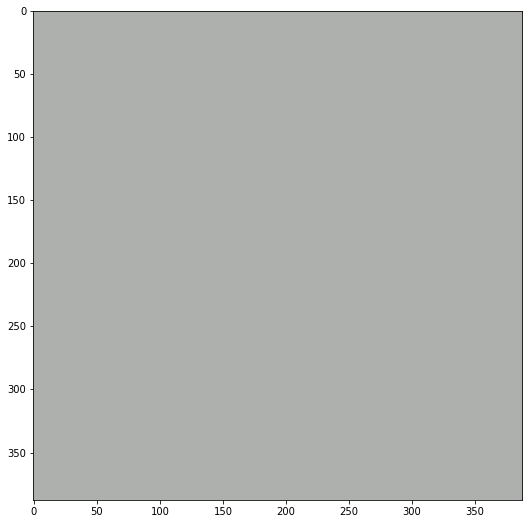

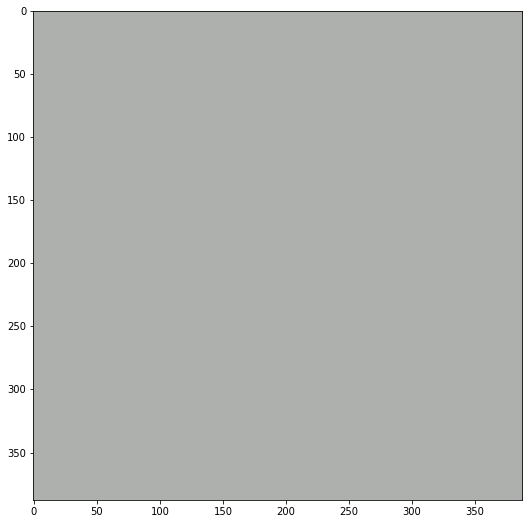

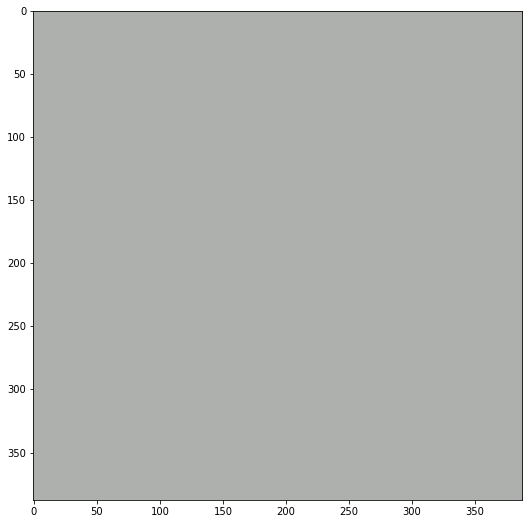

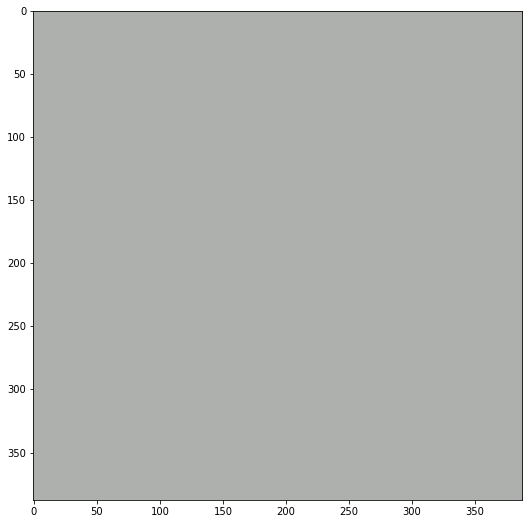

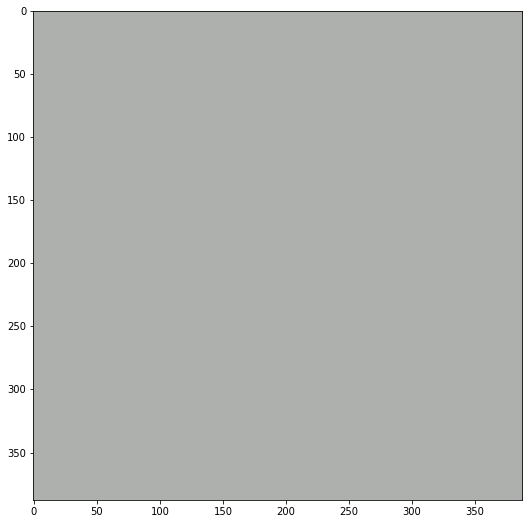

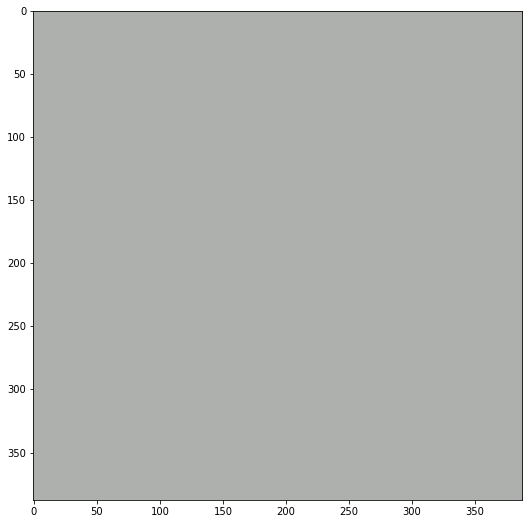

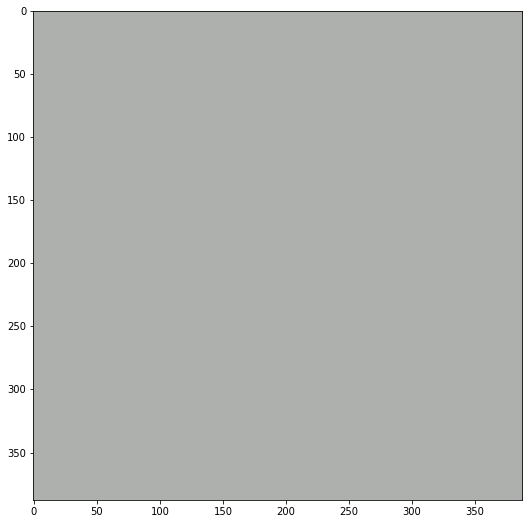

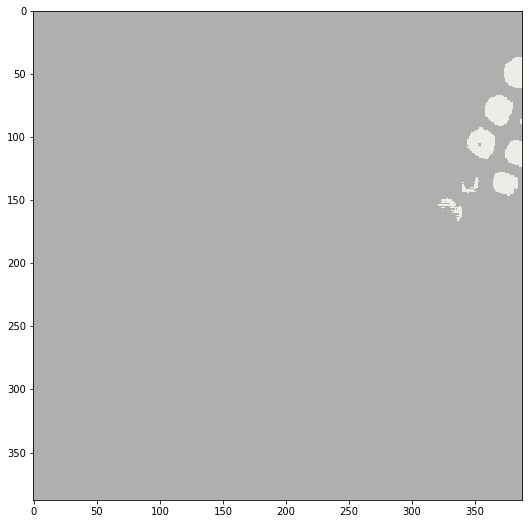

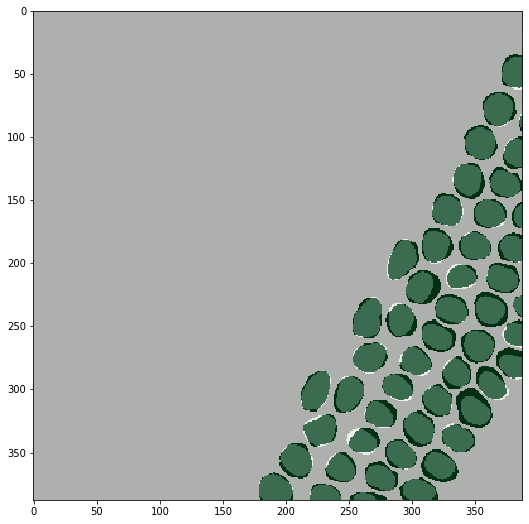

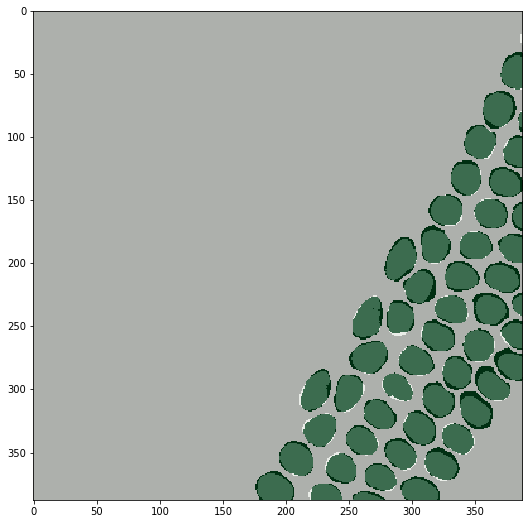

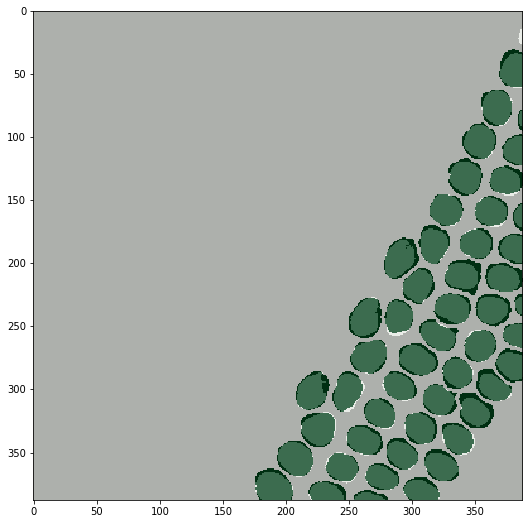

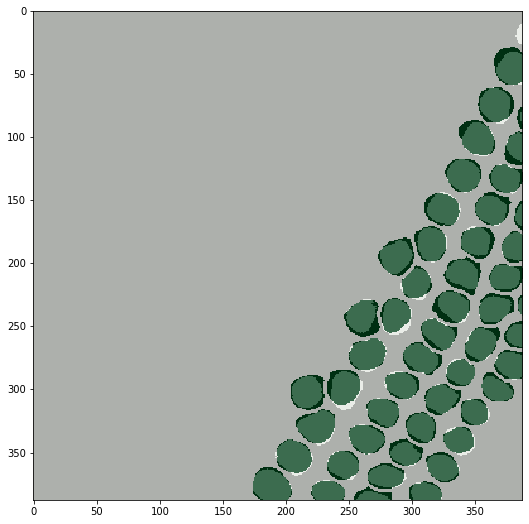

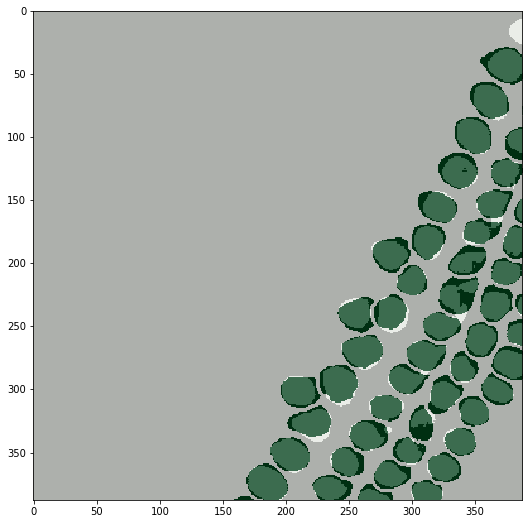

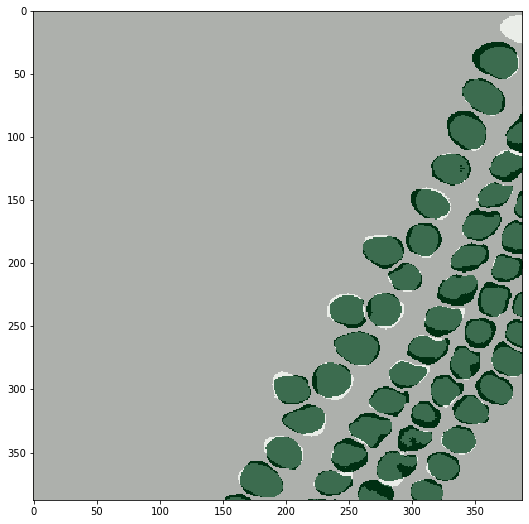

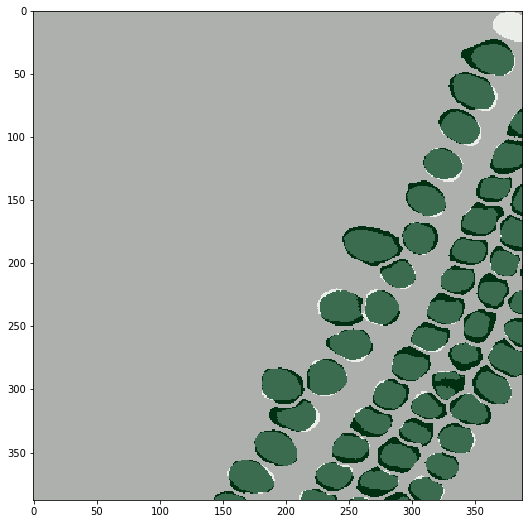

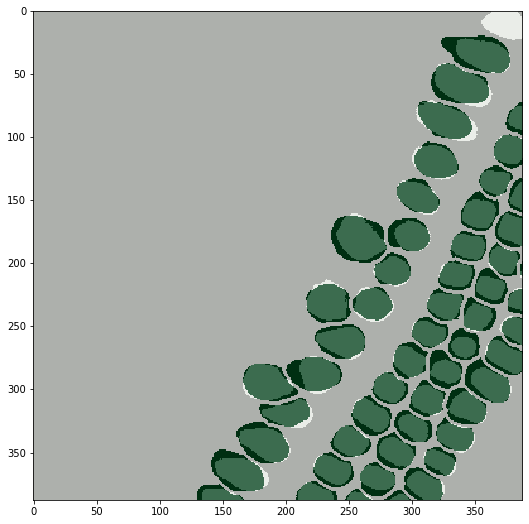

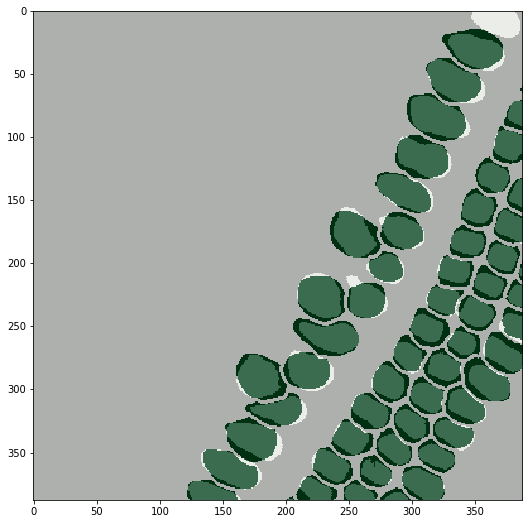

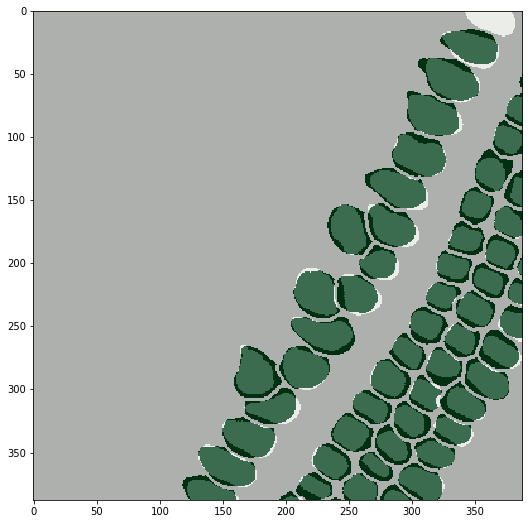

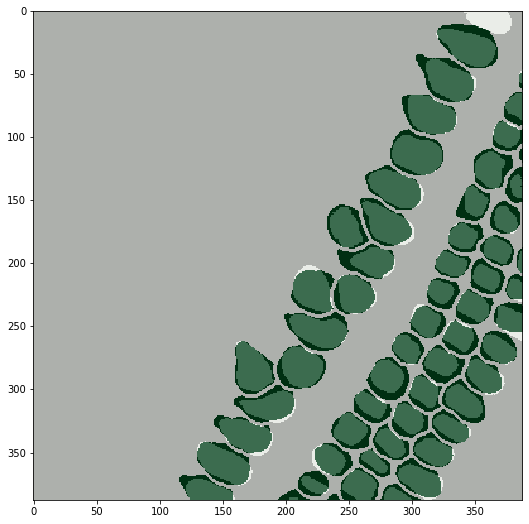

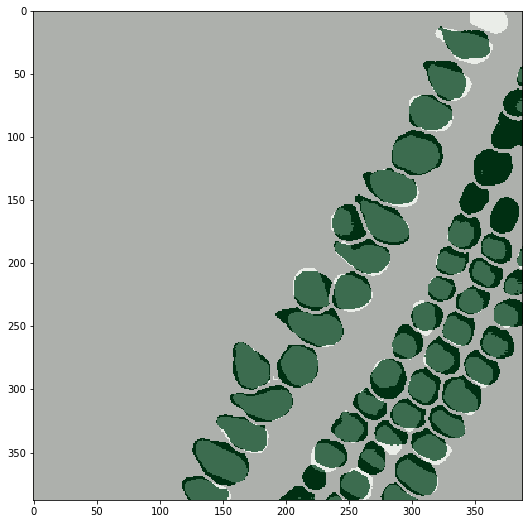

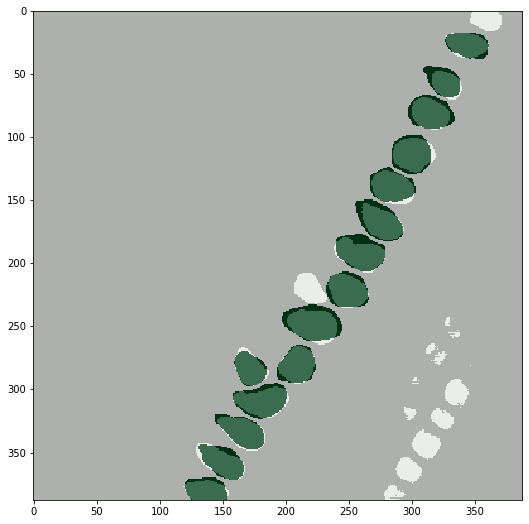

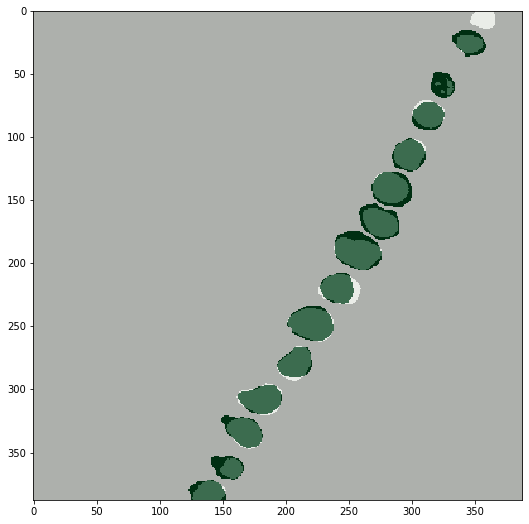

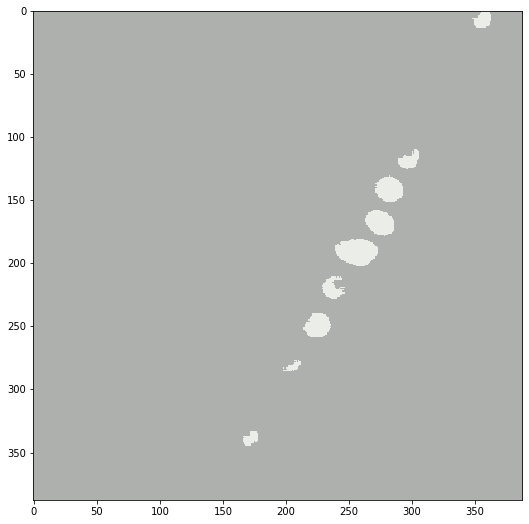

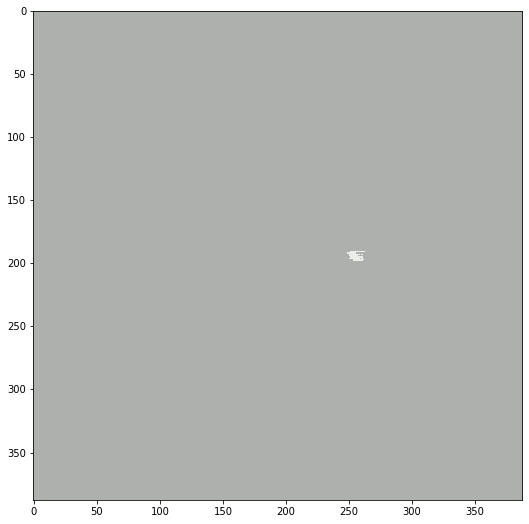

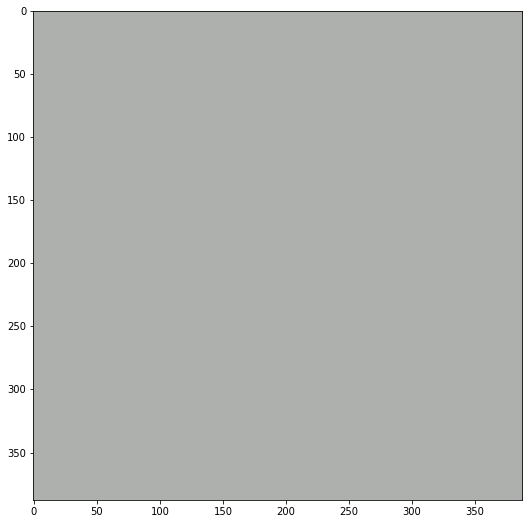

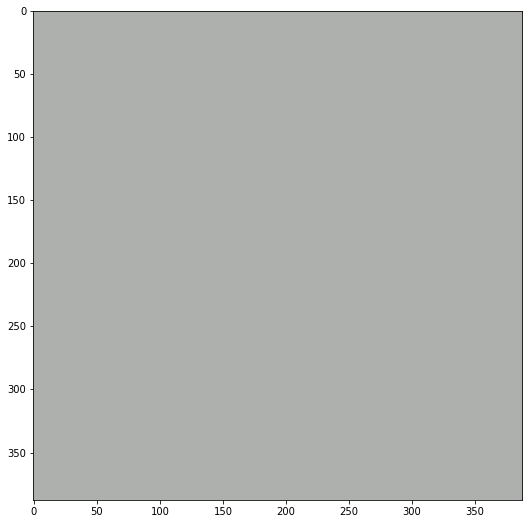

IndexError: index 27 is out of bounds for dimension 4 with size 27

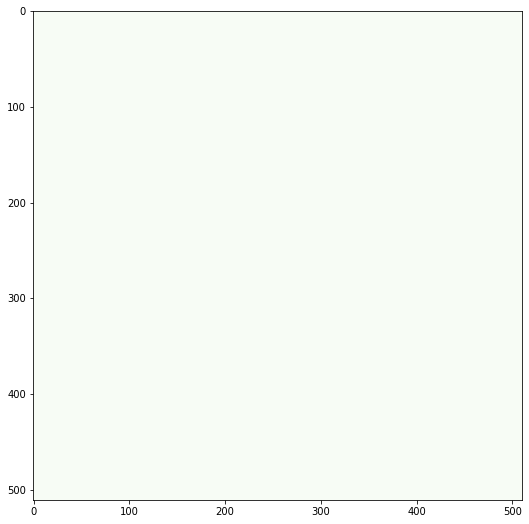

In [12]:
image, mask, pwl  = val_data[5]
#test.eval()
#test.cpu()
with torch.no_grad(): 
    out = test(image.float().cuda())

pred = F.sigmoid(out) > .5
for i in range(image.shape[-1]):
    plt.figure(figsize=(9,9))
    #plt.imshow(image[0,[0,2,1],:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    #plt.imshow(image[0,0:3,:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    plt.imshow(mask[0,0,:,:,i].float(), cmap = 'Greens')
    plt.imshow(pred[0,0,:,:,i].cpu().detach().numpy(), cmap=plt.cm.nipy_spectral,alpha=.3)
    plt.show()
